# Data Exploration Rental Prediction

### General Information

<p>
    The Business Usecase is:<br>
    <ul>
        <li>Prediced the Rental Pricing in Germany</li>
        <li>What kind of Featurs are the most importaned for a Rental Object</li>
        <li>How important is the Geo Location for the Rental Object</li>
    </ul>
</p>

### General Code

In [1]:
#Import 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import urllib.parse
import time
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler

In [2]:
#Load data 
path = "immo_data.csv"
df = pd.read_csv(path)
pd.set_option('display.max_columns', None)

In [3]:
#Functions for the Code

#creates a Correlation Matrix
def correlation_matrix(df):
    corr = df.corr()
    f, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(corr, square = True,fmt='.2f' ,annot = True)
    
#Creates a Mean for one Dataframe Attribute
def set_maker(df,attribute):
    array = df[attribute].unique()
    help_list = array.tolist()
    attribute_set = set(help_list)
    print(attribute_set)
    if type(help_list[1]) == int or float:
        print("The mean of this Attribute is {}".format(df[attribute].mean()))
    elif type(help_list[1]) == str:
        print("Sorry there is no mean to figute out.")

#Drops Inappropriate Data of one specific Value
def drop_inappropriate(df, attribute, value):
    i = df[df[attribute] == value].shape[0]
    print("There are {} inappropriate Data Points with the Value {}".format(i,value))
    df = df.drop(df[df[attribute] == value].index)
    print("The Datapiont have been Droped, the shape if the Dataframe is now {}".format(df.shape))
    return df

#Drops Inappropriate Data that is bigger than a specific Value
def drop_inappropriate_bigger(df, attribute, value):
    i = df[df[attribute] >= value].shape[0]
    print("There are {} inappropriate Data Points with the Value bigger than {}".format(i,value))
    df = df.drop(df[df[attribute] >= value].index)
    print("The Datapiont have been Droped, the shape if the Dataframe is now {}".format(df.shape))
    return df

#Drops Inappropriate Data that is bigger than a specific Value
def drop_inappropriate_smaller(df, attribute, value):
    i = df[df[attribute] <= value].shape[0]
    print("There are {} inappropriate Data Points with the Value smaller than {}".format(i,value))
    df = df.drop(df[df[attribute] <= value].index)
    print("The Datapiont have been Droped, the shape if the Dataframe is now {}".format(df.shape))
    return df

#Returns the all Column Names that have Categorial Data 
def get_categorical_cols(df):
    categorical_columns = []
    for cols in df.columns:
        if df[cols].dtype == 'object':
            categorical_columns.append(cols)
    return categorical_columns
        
#Creates a Dict with Weights and Names of  Prediction
def get_weight_dict(df, target_var, model):
    columns = []
    for cols in df.columns:
        columns.append(cols)
    columns.remove(target_var)
    try:
        weights = model.feature_importances_
    except AttributeError:
        weights = model.coef_
    weights_dictionary = dict(zip(columns, weights))
    return{k: v for k, v in sorted(weights_dictionary.items(), key=lambda item: item[1], reverse=True)}
 
#Makes a Histogram
def pd_hist(df,bins,attribute=False):
    if bool(attribute) == True:
        test_df = df[attribute]
        hist = test_df.hist(bins=bins,figsize=(20,20))
    else:
        hist = df.hist(bins=bins,figsize=(20,20))

#Feature Scales the hole Dataframe
def feature_scaling(df):
    scaler = MaxAbsScaler()
    # calculate the maximum absolute value
    scaler.fit(df)
    scaler.max_abs_
    # transform the data using the parameters calculated by the fit method
    scaled_data = scaler.transform(df)
    df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
    return df_scaled

#Changes Categorical Data to Numbers
def change_categorical(df):
    cat = get_categorical_cols(df)
    cat_df = df[cat]
    df = df.drop(columns=cat)
    cat_df = cat_df.apply(preprocessing.LabelEncoder().fit_transform)
    df =  pd.concat([df, cat_df], axis=1)
    #df = df.append(cat_df, ignore_index=True)
    #f_all = [df, cat_df]    , ignore_index=True
    #esult = pd.concat(df_all)
    return df

#change categorical data to 0 and 1 columns
def change_categorical_to_dummies(df):
    df_with_dummies = df.copy()
    df_with_dummies = df.drop(columns=["regio1", "regio2", "regio3", "geo_bln", "geo_krs", "petsAllowed", "heatingType", "firingTypes", "typeOfFlat"])
    columns = get_categorical_cols(df_with_dummies)
    dummies_feature = pd.get_dummies(df_with_dummies[columns])
    df_with_dummies = pd.concat([df_with_dummies, dummies_feature], axis=1)
    df_with_dummies = df_with_dummies.drop(columns,axis=1)
    return df_with_dummies
    
    
#
def displot(df, x, y):
    sns.displot(data=df, x=df[y], col=df[x], kde=True)
    plt.show()
   

### First Look into the Data

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
correlation_matrix(df)

## 1. Data Cleaning

### Handeling Null Data

In [4]:
#Inspect how much Null Data there is
df.isna().sum()/len(df)

regio1                      0.000000
serviceCharge               0.025698
heatingType                 0.166844
telekomTvOffer              0.121328
telekomHybridUploadSpeed    0.832546
newlyConst                  0.000000
balcony                     0.000000
picturecount                0.000000
pricetrend                  0.006814
telekomUploadSpeed          0.124077
totalRent                   0.150705
yearConstructed             0.212182
scoutId                     0.000000
noParkSpaces                0.653889
firingTypes                 0.211880
hasKitchen                  0.000000
geo_bln                     0.000000
cellar                      0.000000
yearConstructedRange        0.212182
baseRent                    0.000000
houseNumber                 0.264155
livingSpace                 0.000000
geo_krs                     0.000000
condition                   0.254748
interiorQual                0.419063
petsAllowed                 0.426160
street                      0.000000
s

In [5]:
#See how many Attributes have more than 50% Null Data
df.columns[((df.isna().sum()/len(df)) > 0.50)]

Index(['telekomHybridUploadSpeed', 'noParkSpaces', 'heatingCosts',
       'energyEfficiencyClass', 'lastRefurbish', 'electricityBasePrice',
       'electricityKwhPrice'],
      dtype='object')

In [6]:
#Looking deeper into each Attribute with more than 50% Null Data
    #set_maker(df,"noParkSpaces")
    #df['noParkSpaces'].value_counts()

<br>
<ul>
    <li>telekomHybridUploadSpeed = 83% null (to much null to set with mean and no real corelation to price)
    <li>noParkSpaces = 65% (Will be replaced with 0)
    <li>heatingCosts = 68% (Is know from previos owners and will be sett to mean because in a test is brought 1-2% of accuracy)
    <li>energyEfficiencyClass = 71% (To little Corelation and to many missing)
    <li>lastRefurbish = 70% (A lot of wrong Data and a hight rate if Nan will be cut)
    <li>electricityBasePrice = 82% (Sind seit 2020 veraltet, und viele Fehlende Daten, will be cut)
    <li>electricityKwhPrice = 82% (Cut out, small range of Values and to many Nan)
</ul>
<p> The only Attribute that stays from the list will be no of Parking Spaces
    <br>

In [7]:
#drops Colums with to much Null
df = df.drop(columns=df.columns[((df.isna().sum()/len(df)) > 0.69)])
df.columns

Index(['regio1', 'serviceCharge', 'heatingType', 'telekomTvOffer',
       'newlyConst', 'balcony', 'picturecount', 'pricetrend',
       'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'scoutId',
       'noParkSpaces', 'firingTypes', 'hasKitchen', 'geo_bln', 'cellar',
       'yearConstructedRange', 'baseRent', 'houseNumber', 'livingSpace',
       'geo_krs', 'condition', 'interiorQual', 'petsAllowed', 'street',
       'streetPlain', 'lift', 'baseRentRange', 'typeOfFlat', 'geo_plz',
       'noRooms', 'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange',
       'garden', 'livingSpaceRange', 'regio2', 'regio3', 'description',
       'facilities', 'heatingCosts', 'date'],
      dtype='object')

### Handeling inappropriat Data

In [8]:
#since No. of Parkingspaces are importat for a Arppartmet I think they would put them in the offering
#seting noParkings. from Nan to 0
df["noParkSpaces"] = df["noParkSpaces"].fillna(value=0)

In [9]:
#drop Data pionts in "baseRent" with the Values 0.0
df = drop_inappropriate(df,"baseRent", 0.0)

There are 89 inappropriate Data Points with the Value 0.0
The Datapiont have been Droped, the shape if the Dataframe is now (268761, 44)


In [10]:
#drop Data pionts in "livingSpace" with the Values 0.0
df = drop_inappropriate(df,"livingSpace", 0.0)

There are 64 inappropriate Data Points with the Value 0.0
The Datapiont have been Droped, the shape if the Dataframe is now (268697, 44)


In [11]:
#drop Data pionts in "floor" with the Values bigger than 50
#there are no rental objects higher than 50 floors
df = drop_inappropriate_bigger(df,"floor", 50)

There are 28 inappropriate Data Points with the Value bigger than 50
The Datapiont have been Droped, the shape if the Dataframe is now (268669, 44)


In [12]:
#drop Data pionts in "numberOfFloors" with the Values bigger than 50
#there are no rental objects higher than 50 floors
df = drop_inappropriate_bigger(df,"numberOfFloors", 50)

There are 20 inappropriate Data Points with the Value bigger than 50
The Datapiont have been Droped, the shape if the Dataframe is now (268649, 44)


In [13]:
#drop Data pionts in "noParkSpaces" with the Values bigger than 30
df = drop_inappropriate_bigger(df,"noParkSpaces", 30)

There are 226 inappropriate Data Points with the Value bigger than 30
The Datapiont have been Droped, the shape if the Dataframe is now (268423, 44)


In [14]:
df = drop_inappropriate_bigger(df,"serviceCharge", 1000)
df = drop_inappropriate_smaller(df,"serviceCharge", 0)

There are 134 inappropriate Data Points with the Value bigger than 1000
The Datapiont have been Droped, the shape if the Dataframe is now (268289, 44)
There are 3414 inappropriate Data Points with the Value smaller than 0
The Datapiont have been Droped, the shape if the Dataframe is now (264875, 44)


In [15]:
#To big for the Client
df = drop_inappropriate_bigger(df,"livingSpace", 500)

There are 16 inappropriate Data Points with the Value bigger than 500
The Datapiont have been Droped, the shape if the Dataframe is now (264859, 44)


In [16]:
#To big for the Client
df = drop_inappropriate_bigger(df,"noRooms", 20)

There are 22 inappropriate Data Points with the Value bigger than 20
The Datapiont have been Droped, the shape if the Dataframe is now (264837, 44)


In [17]:
#drop Data pionts in "baseRent" with the Values bigger than 10.000€
#To expencive for the Client
df = drop_inappropriate_bigger(df,"baseRent", 10000)

There are 14 inappropriate Data Points with the Value bigger than 10000
The Datapiont have been Droped, the shape if the Dataframe is now (264823, 44)


In [18]:
#not realistic
df = drop_inappropriate_bigger(df,"heatingCosts", 300)

There are 171 inappropriate Data Points with the Value bigger than 300
The Datapiont have been Droped, the shape if the Dataframe is now (264652, 44)


In [19]:
#To old for the Client
df = drop_inappropriate_smaller(df,"yearConstructed", 1900) #1900
df = drop_inappropriate_bigger(df,"yearConstructed", 2025) #2025

There are 18030 inappropriate Data Points with the Value smaller than 1900
The Datapiont have been Droped, the shape if the Dataframe is now (246622, 44)
There are 5 inappropriate Data Points with the Value bigger than 2025
The Datapiont have been Droped, the shape if the Dataframe is now (246617, 44)


In [20]:
#it is important on witch floor the flat is as long as it's not on 0 (ground Floor) so every Nan will be replaced with 0 
#because taking a mean or median would not make sence
#some people have put 1 for the ground floor and some 0 soo? What to do?
df["floor"] = df["floor"].fillna(value=0)

In [21]:
#will be changes to numbers so all Methods can work with it
df["petsAllowed"] = df["petsAllowed"].fillna(value='no')
df["petsAllowed"] = df["petsAllowed"].replace(['no'],0)
df["petsAllowed"] = df["petsAllowed"].replace(['negotiable'],5)
df["petsAllowed"] = df["petsAllowed"].replace(['yes'],10)

### Drop not usefull Data

<h4> Explanation why they are not Usefull</h4>
    <ul>
        <li>description = No need because there are no direct information on the House Price, could be explord in side Project
        <li>livingSpaceRange = Is reprecented in other Attributes.
        <li>scoutId = Just a Immoscout intern ID
        <li>street = Not importat
        <li>streetPlain = Same as Steet Name
        <li>houseNumber = Not important
        <li>date = Just the scraping date.
        <li>facilities = Same as Description
        <li>totalRent = is just a combination of Rent and serviceCharges, still has no correlation
        <li>telekomUploadSpeed = Has no Corralation and makes no sens to keep everyone can choose the Speed they want to pay for

In [22]:
#drop Attributes that are unimportant 
df = df.drop(columns=['description','livingSpaceRange','scoutId','street','streetPlain','houseNumber','date','facilities','totalRent','telekomUploadSpeed'])

### Fill Numeric Null with mean

In [23]:
#Inspect the mean of the Data
df._get_numeric_data().mean()

serviceCharge             151.160083
newlyConst                  0.085169
balcony                     0.631818
picturecount                9.627528
pricetrend                  3.381054
yearConstructed          1974.631973
noParkSpaces                0.408455
hasKitchen                  0.339620
cellar                      0.651983
yearConstructedRange        3.969567
baseRent                  634.414968
livingSpace                73.167328
petsAllowed                 2.097199
lift                        0.240138
baseRentRange               3.729451
geo_plz                 37840.977455
noRooms                     2.632667
thermalChar               113.400470
floor                       1.704736
numberOfFloors              3.523369
noRoomsRange                2.576643
garden                      0.193648
heatingCosts               74.027935
dtype: float64

In [24]:
#fill the Nan with mean
df.fillna(df._get_numeric_data().mean(),inplace = True)

In [25]:
#Check the remaining Null Values
df._get_numeric_data().mean()

serviceCharge             151.160083
newlyConst                  0.085169
balcony                     0.631818
picturecount                9.627528
pricetrend                  3.381054
yearConstructed          1974.631973
noParkSpaces                0.408455
hasKitchen                  0.339620
cellar                      0.651983
yearConstructedRange        3.969567
baseRent                  634.414968
livingSpace                73.167328
petsAllowed                 2.097199
lift                        0.240138
baseRentRange               3.729451
geo_plz                 37840.977455
noRooms                     2.632667
thermalChar               113.400470
floor                       1.704736
numberOfFloors              3.523369
noRoomsRange                2.576643
garden                      0.193648
heatingCosts               74.027935
dtype: float64

### The Categorical Data will be handelt in the Prediction part because it's better to Visualiz this way

## 2. Data Visualization

### General Visualization

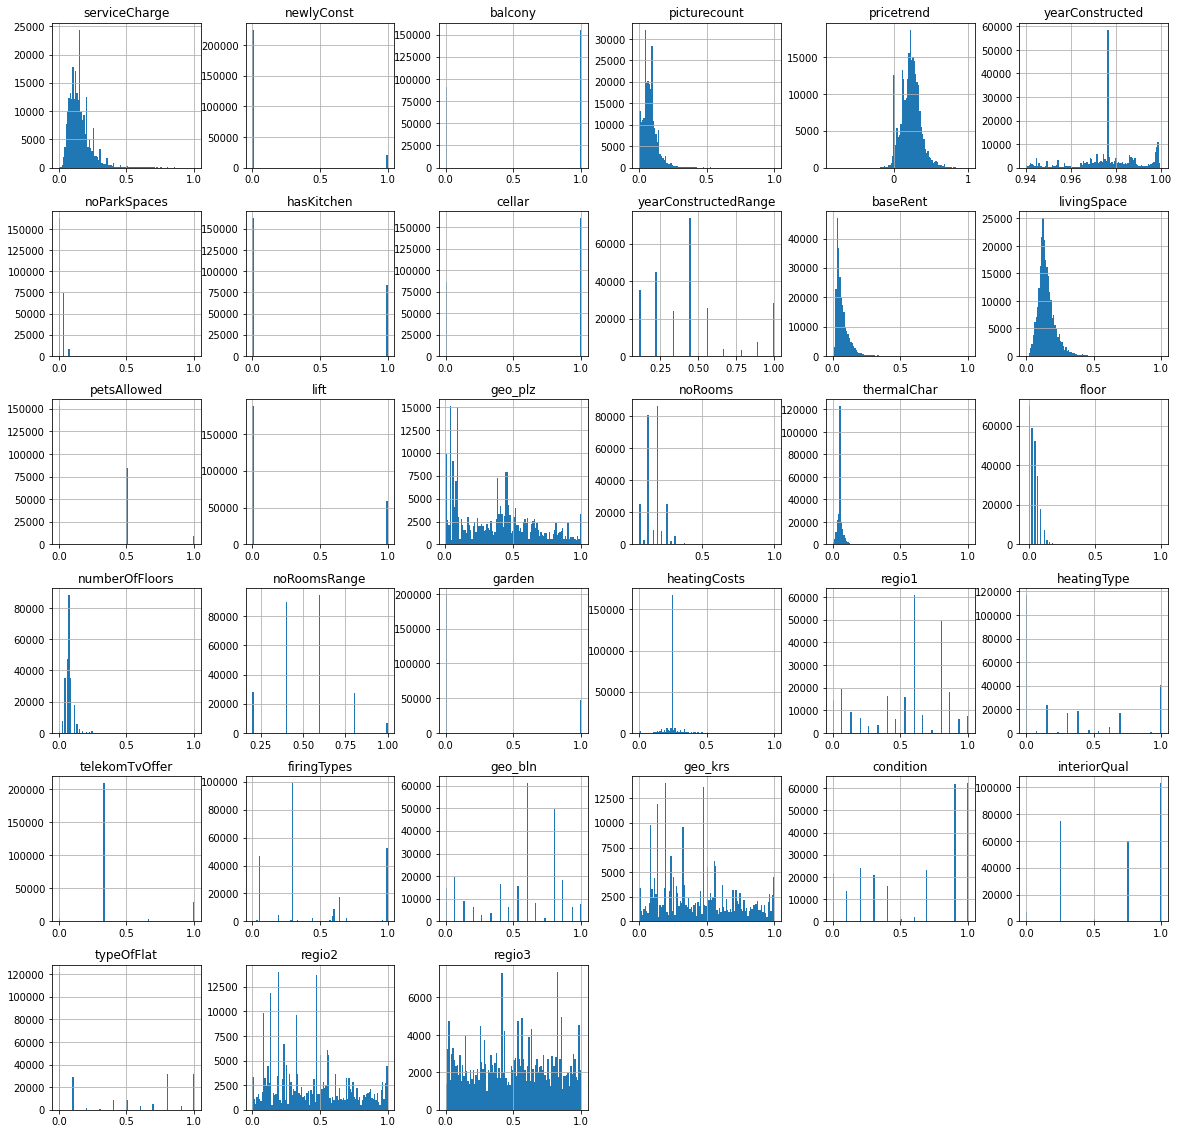

In [54]:
pd_hist(df,100)

In [ ]:
correlation_matrix(df)

In [ ]:
df.columns

### Development of rental prices in relation to the variables with the highest correlations

<ul>
    <li>Living Space 
    <li> Service Charge 

In [ ]:
sns.regplot(x='livingSpace', y='baseRent', data=df, scatter_kws={"alpha":0.3,"s":20})

In [ ]:
sns.regplot(x = 'serviceCharge', y= 'baseRent', data=df, scatter_kws={"alpha":0.3,"s":20})

### Rental prices in comparison of the German states

In [ ]:
plt.figure(figsize=(20,10))

sns.barplot(x=df.regio1, y=df.baseRent, ci = None)
plt.ylim([25, 1250])
plt.xticks(rotation='vertical')
plt.show()

## 3. Data Prediction

### Handeling Categorical Data

In [26]:
df

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,yearConstructed,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,livingSpace,geo_krs,condition,interiorQual,petsAllowed,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,regio2,regio3,heatingCosts
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,False,False,6,4.62,1965.0,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,86.00,Dortmund,well_kept,normal,0,False,4,ground_floor,44269,4.0,181.40000,1.0,3.000000,4,True,Dortmund,Schüren,74.027935
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,True,True,8,2.72,2019.0,1.0,NaN,False,Sachsen,True,9.0,965.0,83.80,Dresden,first_time_use,sophisticated,0,True,6,apartment,1097,3.0,113.40047,3.0,4.000000,3,False,Dresden,Äußere_Neustadt_Antonstadt,74.027935
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,False,True,9,1.53,1964.0,0.0,district_heating,False,Sachsen,False,2.0,343.0,58.15,Mittelsachsen_Kreis,NaN,NaN,0,False,2,other,9599,3.0,86.00000,3.0,3.523369,3,False,Mittelsachsen_Kreis,Freiberg,87.230000
4,Bremen,138.00,self_contained_central_heating,NaN,False,True,19,2.46,1950.0,0.0,gas,False,Bremen,False,1.0,765.0,84.97,Bremen,refurbished,NaN,0,False,5,apartment,28213,3.0,188.90000,1.0,3.523369,3,False,Bremen,Neu_Schwachhausen,74.027935
5,Schleswig_Holstein,142.00,gas_heating,NONE,False,True,5,4.48,1999.0,0.0,gas,True,Schleswig_Holstein,False,5.0,315.2,53.43,Schleswig_Flensburg_Kreis,well_kept,NaN,0,False,2,apartment,24891,2.0,165.00000,0.0,3.523369,2,False,Schleswig_Flensburg_Kreis,Struxdorf,74.027935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,Bayern,90.00,heat_pump,ONE_YEAR_FREE,False,True,0,2.74,2016.0,1.0,geothermal,False,Bayern,True,9.0,820.0,90.00,Weilheim_Schongau_Kreis,mint_condition,sophisticated,0,False,6,roof_storey,82390,3.0,113.40047,0.0,3.523369,3,False,Weilheim_Schongau_Kreis,Eberfing,74.027935
268846,Hessen,220.00,gas_heating,NaN,False,True,12,6.49,1983.0,1.0,gas,True,Hessen,False,4.0,930.0,115.00,Bergstraße_Kreis,well_kept,sophisticated,5,False,6,apartment,68519,3.5,113.40047,1.0,1.000000,3,False,Bergstraße_Kreis,Viernheim,74.027935
268847,Hessen,220.00,central_heating,ONE_YEAR_FREE,False,True,21,2.90,1965.0,1.0,gas,False,Hessen,True,2.0,650.0,95.00,Limburg_Weilburg_Kreis,well_kept,NaN,5,False,5,apartment,65552,4.0,160.77000,1.0,2.000000,4,True,Limburg_Weilburg_Kreis,Limburg_an_der_Lahn,74.027935
268848,Nordrhein_Westfalen,175.00,heat_pump,NaN,True,True,16,4.39,2019.0,1.0,gas,False,Nordrhein_Westfalen,True,9.0,840.0,70.00,Köln,first_time_use,sophisticated,0,True,6,apartment,51069,2.0,24.70000,0.0,5.000000,2,False,Köln,Dellbrück,40.000000


In [27]:
#Method 1: Change categorical data to 0 and 1 columns
df_dummies = change_categorical_to_dummies(df)

In [28]:
#Method 2: Changes the Categorical Data to Numbers
df = change_categorical(df) 

In [29]:
df

,serviceCharge,newlyConst,balcony,picturecount,pricetrend,yearConstructed,noParkSpaces,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,petsAllowed,lift,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,heatingCosts,regio1,heatingType,telekomTvOffer,firingTypes,geo_bln,geo_krs,condition,interiorQual,typeOfFlat,regio2,regio3
0,245.00,False,False,6,4.62,1965.0,1.0,False,True,2.0,595.0,86.00,0,False,4,44269,4.0,181.40000,1.0,3.000000,4,True,74.027935,9,0,1,82,9,79,9,1,1,79,6883
2,255.00,True,True,8,2.72,2019.0,1.0,False,True,9.0,965.0,83.80,0,True,6,1097,3.0,113.40047,3.0,4.000000,3,False,74.027935,12,4,1,127,12,80,0,3,0,80,8541
3,58.15,False,True,9,1.53,1964.0,0.0,False,False,2.0,343.0,58.15,0,False,2,9599,3.0,86.00000,3.0,3.523369,3,False,87.230000,12,2,1,7,12,230,10,4,5,230,2148
4,138.00,False,True,19,2.46,1950.0,0.0,False,False,1.0,765.0,84.97,0,False,5,28213,3.0,188.90000,1.0,3.523369,3,False,74.027935,4,9,3,37,4,49,7,4,0,49,5152
5,142.00,False,True,5,4.48,1999.0,0.0,True,False,5.0,315.2,53.43,0,False,2,24891,2.0,165.00000,0.0,3.523369,2,False,74.027935,14,5,0,37,14,334,9,4,0,334,7255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,90.00,False,True,0,2.74,2016.0,1.0,False,True,9.0,820.0,90.00,0,False,6,82390,3.0,113.40047,0.0,3.523369,3,False,74.027935,1,6,1,57,1,394,3,3,8,394,1640
268846,220.00,False,True,12,6.49,1983.0,1.0,True,False,4.0,930.0,115.00,5,False,6,68519,3.5,113.40047,1.0,1.000000,3,False,74.027935,6,5,3,37,6,34,9,3,0,34,7722
268847,220.00,False,True,21,2.90,1965.0,1.0,False,True,2.0,650.0,95.00,5,False,5,65552,4.0,160.77000,1.0,2.000000,4,True,74.027935,6,0,1,37,6,201,9,4,0,201,4428
268848,175.00,True,True,16,4.39,2019.0,1.0,False,True,9.0,840.0,70.00,0,True,6,51069,2.0,24.70000,0.0,5.000000,2,False,40.000000,9,6,3,37,9,190,0,3,0,190,1389


In [30]:
df_dummies

,serviceCharge,newlyConst,balcony,picturecount,pricetrend,yearConstructed,noParkSpaces,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,lift,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,heatingCosts,telekomTvOffer_NONE,telekomTvOffer_ONE_YEAR_FREE,telekomTvOffer_ON_DEMAND,condition_first_time_use,condition_first_time_use_after_refurbishment,condition_fully_renovated,condition_mint_condition,condition_modernized,condition_need_of_renovation,condition_negotiable,condition_refurbished,condition_ripe_for_demolition,condition_well_kept,interiorQual_luxury,interiorQual_normal,interiorQual_simple,interiorQual_sophisticated
0,245.00,False,False,6,4.62,1965.0,1.0,False,True,2.0,595.0,86.00,False,4,44269,4.0,181.40000,1.0,3.000000,4,True,74.027935,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,255.00,True,True,8,2.72,2019.0,1.0,False,True,9.0,965.0,83.80,True,6,1097,3.0,113.40047,3.0,4.000000,3,False,74.027935,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,58.15,False,True,9,1.53,1964.0,0.0,False,False,2.0,343.0,58.15,False,2,9599,3.0,86.00000,3.0,3.523369,3,False,87.230000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,138.00,False,True,19,2.46,1950.0,0.0,False,False,1.0,765.0,84.97,False,5,28213,3.0,188.90000,1.0,3.523369,3,False,74.027935,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,142.00,False,True,5,4.48,1999.0,0.0,True,False,5.0,315.2,53.43,False,2,24891,2.0,165.00000,0.0,3.523369,2,False,74.027935,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,90.00,False,True,0,2.74,2016.0,1.0,False,True,9.0,820.0,90.00,False,6,82390,3.0,113.40047,0.0,3.523369,3,False,74.027935,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
268846,220.00,False,True,12,6.49,1983.0,1.0,True,False,4.0,930.0,115.00,False,6,68519,3.5,113.40047,1.0,1.000000,3,False,74.027935,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
268847,220.00,False,True,21,2.90,1965.0,1.0,False,True,2.0,650.0,95.00,False,5,65552,4.0,160.77000,1.0,2.000000,4,True,74.027935,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
268848,175.00,True,True,16,4.39,2019.0,1.0,False,True,9.0,840.0,70.00,True,6,51069,2.0,24.70000,0.0,5.000000,2,False,40.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


### Additional (specialy needed for KNN)

In [31]:
#replaces bool with numbers otherwise the featurescaling would not work
bool_list = ["newlyConst", "balcony", "hasKitchen", "cellar", "lift" , "garden" ]
for x in bool_list:
    df[x] = df[x].astype(int)

In [32]:
df = feature_scaling(df)

In [33]:
df_dummies = feature_scaling(df_dummies)

In [ ]:
df = df.drop(['baseRentRange'], axis=1)

In [46]:
df_dummies = df_dummies.drop(['baseRentRange'], axis=1)

In [35]:
df.head()

,serviceCharge,newlyConst,balcony,picturecount,pricetrend,yearConstructed,noParkSpaces,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,petsAllowed,lift,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,heatingCosts,regio1,heatingType,telekomTvOffer,firingTypes,geo_bln,geo_krs,condition,interiorQual,typeOfFlat,regio2,regio3
0,0.245491,0.0,0.0,0.049587,0.309651,0.971810,0.035714,0.0,1.0,0.222222,0.066854,0.179167,0.0,0.0,0.442699,0.2500,0.090882,0.022222,0.066667,0.8,1.0,0.246842,0.600000,0.000000,0.333333,0.645669,0.600000,0.188995,0.9,0.25,0.1,0.188995,0.803901
1,0.255511,1.0,1.0,0.066116,0.182306,0.998516,0.035714,0.0,1.0,1.000000,0.108427,0.174583,0.0,1.0,0.010970,0.1875,0.056814,0.066667,0.088889,0.6,0.0,0.246842,0.800000,0.307692,0.333333,1.000000,0.800000,0.191388,0.0,0.75,0.0,0.191388,0.997547
2,0.058267,0.0,1.0,0.074380,0.102547,0.971316,0.000000,0.0,0.0,0.222222,0.038539,0.121146,0.0,0.0,0.095992,0.1875,0.043086,0.066667,0.078297,0.6,0.0,0.290864,0.800000,0.153846,0.333333,0.055118,0.800000,0.550239,1.0,1.00,0.5,0.550239,0.250876
3,0.138277,0.0,1.0,0.157025,0.164879,0.964392,0.000000,0.0,0.0,0.111111,0.085955,0.177021,0.0,0.0,0.282136,0.1875,0.094639,0.022222,0.078297,0.6,0.0,0.246842,0.266667,0.692308,1.000000,0.291339,0.266667,0.117225,0.7,1.00,0.0,0.117225,0.601729
4,0.142285,0.0,1.0,0.041322,0.300268,0.988625,0.000000,1.0,0.0,0.555556,0.035416,0.111312,0.0,0.0,0.248915,0.1250,0.082665,0.000000,0.078297,0.4,0.0,0.246842,0.933333,0.384615,0.000000,0.291339,0.933333,0.799043,0.9,1.00,0.0,0.799043,0.847349


### General prediction preparation

In [36]:
#import the sklearn libarys 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
import math

In [37]:
X=df.copy()
y = df['baseRent']  #np.log() #with the log the prediction score gets better, but we found no usecase for that

X.drop(['baseRent'],axis=1,inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle= True)

In [38]:
XD=df_dummies.copy()
yd = df_dummies['baseRent']  #np.log() #with the log the prediction score gets better, but we found no usecase for that

XD.drop(['baseRent'],axis=1,inplace = True)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(XD, yd, test_size=0.33, shuffle= True)

### Linear Models

Score:  0.7373185875049746
RMSE:  0.026980090026801944


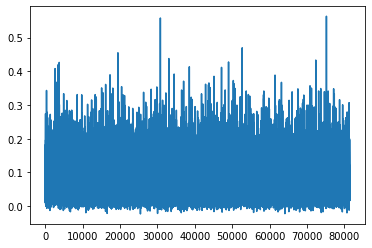

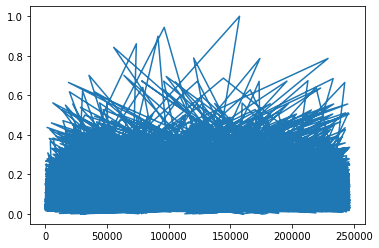

Weights:


{'regio2': 17225490500.983917,
 'regio1': 46763260.90506441,
 'livingSpace': 0.43933998802880564,
 'serviceCharge': 0.14844594224167199,
 'pricetrend': 0.06419936397755205,
 'numberOfFloors': 0.0444884597099555,
 'yearConstructedRange': 0.03432741819401479,
 'picturecount': 0.02932058154927949,
 'floor': 0.019962709670470327,
 'hasKitchen': 0.010252365240516701,
 'newlyConst': 0.006032893408918674,
 'lift': 0.005662694195840632,
 'heatingType': 0.003724276395887317,
 'geo_plz': 0.0035039923331481237,
 'regio3': 0.0021678373512564195,
 'cellar': 0.0014444905205923677,
 'telekomTvOffer': 0.0010193933433566022,
 'balcony': 0.0007377354886615546,
 'typeOfFlat': 0.0007132506918231182,
 'interiorQual': -0.00028732801370736033,
 'garden': -0.0008609529075015877,
 'firingTypes': -0.0009547457895667929,
 'petsAllowed': -0.003440778198425861,
 'noParkSpaces': -0.004874074269834699,
 'noRoomsRange': -0.006243016847701607,
 'condition': -0.007794883924512389,
 'heatingCosts': -0.00863265866388576,

In [39]:
#with label encoder 
lineReg = LinearRegression()
lineReg.fit(X_train, y_train)

prediction = lineReg.predict(X_test)
#f1_score = f1_score(y_test, prediction, average='micro')
score_lineReg = lineReg.score(X_test,y_test)
mse_error_lineReg =  metrics.mean_squared_error(y_test, prediction)
rmse_lineReg = math.sqrt(mse_error_lineReg)
print('Score: ', score_lineReg)
print('RMSE: ', rmse_lineReg)
#print('F1 Score: ', f1_score)


plt.plot(prediction)
plt.show()
plt.plot(y_test)
plt.show()

print("Weights:")
weights_lineReg = get_weight_dict(df, 'baseRent', lineReg)
weight_items_lineReg = weights_lineReg.items()
first_weights_lineReg = list(weight_items_lineReg)[:2]
weights_lineReg

Score:  0.817126626536204
MSE:  0.02249841298286906


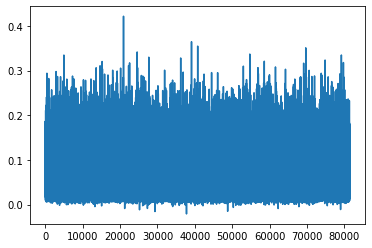

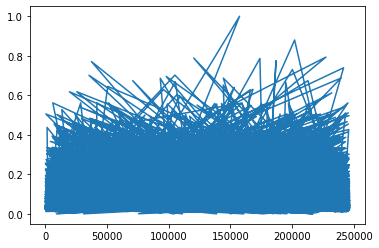

Weights:


{'livingSpace': 0.21703936601953377,
 'geo_plz': 0.12571510419742696,
 'serviceCharge': 0.09197994894193023,
 'noRoomsRange': 0.03741267889827989,
 'numberOfFloors': 0.03517654961716858,
 'interiorQual_normal': 0.025744660449809276,
 'thermalChar': 0.024847699956589288,
 'pricetrend': 0.01784712674398824,
 'yearConstructedRange': 0.005927693908511364,
 'hasKitchen': 0.004368516768334079,
 'newlyConst': 0.0033532564789982428,
 'condition_modernized': 0.0015276410698113656,
 'interiorQual_sophisticated': 0.0014702999707364298,
 'cellar': 0.0013034983739559757,
 'condition_first_time_use': 0.0011159411148891165,
 'telekomTvOffer_ON_DEMAND': 0.0010476325513566608,
 'lift': 0.0009745516558503113,
 'condition_ripe_for_demolition': 0.0008061129750359297,
 'condition_first_time_use_after_refurbishment': 0.00046722178635310864,
 'heatingCosts': -0.00021792655533877013,
 'condition_fully_renovated': -0.0002711962490524725,
 'condition_mint_condition': -0.0004293526503547558,
 'interiorQual_simpl

In [47]:
#with dummies
lineReg = LinearRegression()
lineReg.fit(X_train_d, y_train_d)

prediction = lineReg.predict(X_test_d)
#f1_score = f1_score(y_test, prediction, average='micro')
score_lineReg = lineReg.score(X_test_d,y_test_d)
mse_error_lineReg =  metrics.mean_squared_error(y_test_d, prediction)
rmse_lineReg = math.sqrt(mse_error_lineReg)
print('Score: ', score_lineReg)
print('MSE: ', rmse_lineReg)
#print('F1 Score: ', f1_score)


plt.plot(prediction)
plt.show()
plt.plot(y_test_d)
plt.show()

print("Weights:")
weights_lineReg = get_weight_dict(df_dummies, 'baseRent', lineReg)
weight_items_lineReg = weights_lineReg.items()
first_weights_lineReg = list(weight_items_lineReg)[:2]
weights_lineReg

Score:  0.7373187990397689
MSE:  0.0007279246716631859


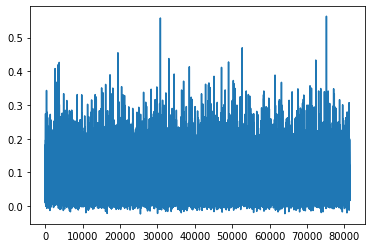

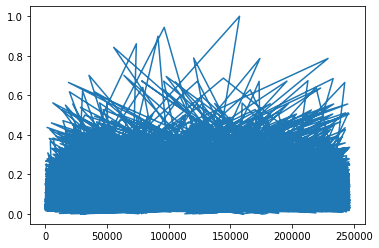

Weights:


{'livingSpace': 0.4393303531278407,
 'serviceCharge': 0.14844655923353833,
 'pricetrend': 0.06418688548592645,
 'numberOfFloors': 0.04448550023230369,
 'yearConstructedRange': 0.03431852459800144,
 'picturecount': 0.029348325705037166,
 'floor': 0.019954324151601012,
 'hasKitchen': 0.010251316478597304,
 'newlyConst': 0.006033942689298281,
 'lift': 0.005662840508030796,
 'heatingType': 0.003726186380683725,
 'geo_plz': 0.003508384118565433,
 'regio3': 0.0021687621657270344,
 'cellar': 0.0014439112463002738,
 'telekomTvOffer': 0.001017738464623033,
 'balcony': 0.0007367339807415606,
 'typeOfFlat': 0.0007108759318516117,
 'interiorQual': -0.00028912193580246697,
 'garden': -0.000860867886099101,
 'firingTypes': -0.0009553460409608806,
 'regio2': -0.002036884255587231,
 'geo_krs': -0.0020368842564708806,
 'petsAllowed': -0.0034387970168577625,
 'noParkSpaces': -0.004865757990618792,
 'noRoomsRange': -0.006232821156591745,
 'condition': -0.007794882210875292,
 'heatingCosts': -0.0086276146

In [41]:
#with label encoder
reg = linear_model.Ridge (alpha = .001)
reg.fit(X_train, y_train)
prediction = reg.predict(X_test)
score_reg = reg.score(X_test, y_test)
mse_error_reg =  metrics.mean_squared_error(y_test, prediction)
rmse_reg = math.sqrt(mse_error_reg)
print('Score: ', score_reg)
print('MSE: ', mse_error_reg)


plt.plot(reg.predict(X_test))
plt.show()
plt.plot(y_test)
plt.show()

print("Weights:")
weights_reg = get_weight_dict(df, 'baseRent', reg)
weight_items_reg = weights_lineReg.items()
first_weights_reg = list(weight_items_reg)[:2]
weights_reg

Score:  0.8171266277855354
MSE:  0.0005061785832896837


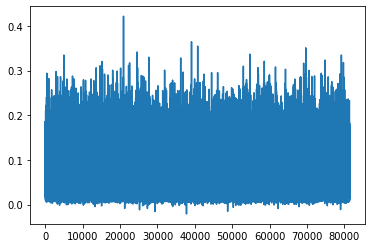

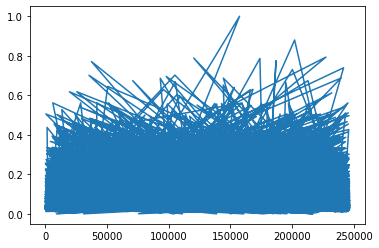

Weights:


{'livingSpace': 0.21703834759945542,
 'geo_plz': 0.12571533380862368,
 'serviceCharge': 0.09198005423322243,
 'noRoomsRange': 0.03741234177785459,
 'numberOfFloors': 0.035176125279273864,
 'interiorQual_normal': 0.025744703675085613,
 'thermalChar': 0.024846748798556376,
 'pricetrend': 0.017847034438031373,
 'yearConstructedRange': 0.005926317667108289,
 'hasKitchen': 0.0043685185538616745,
 'newlyConst': 0.0033534263123184234,
 'condition_modernized': 0.0015277166730697205,
 'interiorQual_sophisticated': 0.001470314649363363,
 'cellar': 0.0013034888127754613,
 'condition_first_time_use': 0.0011159277008722902,
 'telekomTvOffer_ON_DEMAND': 0.0010476231876909519,
 'lift': 0.0009745711624600269,
 'condition_ripe_for_demolition': 0.0008061277255513195,
 'condition_first_time_use_after_refurbishment': 0.0004672816534404063,
 'heatingCosts': -0.00021790572563685449,
 'condition_fully_renovated': -0.00027121048471237974,
 'condition_mint_condition': -0.0004293662922330037,
 'interiorQual_sim

In [48]:
#with dummies
reg = linear_model.Ridge (alpha = .001)
reg.fit(X_train_d, y_train_d)
prediction = reg.predict(X_test_d)
score_reg = reg.score(X_test_d, y_test_d)
mse_error_reg =  metrics.mean_squared_error(y_test_d, prediction)
rmse_reg = math.sqrt(mse_error_reg)
print('Score: ', score_reg)
print('MSE: ', mse_error_reg)


plt.plot(reg.predict(X_test_d))
plt.show()
plt.plot(y_test_d)
plt.show()

print("Weights:")
weights_reg = get_weight_dict(df_dummies, 'baseRent', reg)
weight_items_reg = weights_lineReg.items()
first_weights_reg = list(weight_items_reg)[:2]
weights_reg

Score:  0.7019481662752771
RMSE:  0.028739196517576535


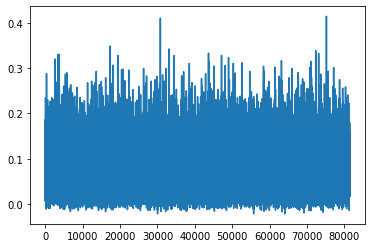

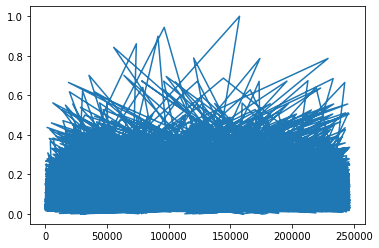

Weights:


{'livingSpace': 0.18114939970586436,
 'serviceCharge': 0.16989468801801758,
 'pricetrend': 0.06706397890440015,
 'picturecount': 0.04102754975444922,
 'noRoomsRange': 0.028868315191518782,
 'noRooms': 0.018029077409953978,
 'yearConstructedRange': 0.014758155945528706,
 'hasKitchen': 0.012324516661847624,
 'lift': 0.00965946222829041,
 'newlyConst': 0.008969845945785046,
 'heatingCosts': 0.008243511642913613,
 'noParkSpaces': 0.008230653382451629,
 'numberOfFloors': 0.006646991342457417,
 'geo_plz': 0.004993543892530727,
 'heatingType': 0.0044842435063026575,
 'floor': 0.0026114843390760522,
 'typeOfFlat': 0.0023519096683843463,
 'regio3': 0.0023202761918765576,
 'balcony': 0.0021295689455232006,
 'telekomTvOffer': 0.0012569745220497137,
 'cellar': 0.0005766135137989828,
 'firingTypes': 0.0004608831096484272,
 'garden': 0.0003989421820167037,
 'interiorQual': -0.0011063826574104264,
 'geo_krs': -0.0026038254557204455,
 'regio2': -0.0026038254557204455,
 'petsAllowed': -0.00326081856550

In [43]:
#with label encoder
SGD = linear_model.SGDRegressor(alpha = 0.001)
SGD.fit(X_train, y_train)
prediction = SGD.predict(X_test)
score_sgd = SGD.score(X_test, y_test)
mse_error_sgd =  metrics.mean_squared_error(y_test, prediction)
rmse_sgd = math.sqrt(mse_error_sgd)
print('Score: ', score_sgd)
print('RMSE: ', rmse_sgd)

plt.plot(SGD.predict(X_test))
plt.show()
plt.plot(y_test)
plt.show()

print("Weights:")
weights_sgd = get_weight_dict(df, 'baseRent', SGD)
weight_items_sgd = weights_sgd.items()
first_weights_sgd = list(weight_items_sgd)[:2]
weights_sgd

Score:  0.8042057600186411
RMSE:  0.023279658325152684


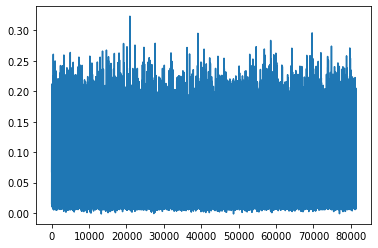

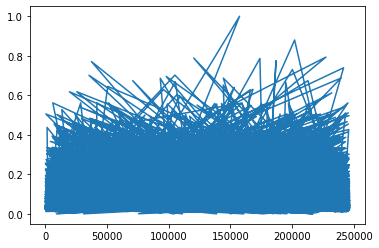

Weights:


{'geo_plz': 0.1396852134716326,
 'serviceCharge': 0.08672764074812334,
 'livingSpace': 0.08113687350759041,
 'interiorQual_normal': 0.027793224771189277,
 'pricetrend': 0.013585512607590958,
 'numberOfFloors': 0.012882698854044798,
 'noRoomsRange': 0.01052615418089161,
 'picturecount': 0.008294047030634674,
 'thermalChar': 0.00684815427732037,
 'hasKitchen': 0.003440863653072618,
 'newlyConst': 0.0029038814252308467,
 'lift': 0.0023396518296516407,
 'condition_first_time_use': 0.001493023053382395,
 'telekomTvOffer_NONE': 0.0013385260014098592,
 'condition_modernized': 0.0011877135197635416,
 'condition_ripe_for_demolition': 0.0011249756104302236,
 'interiorQual_sophisticated': 0.0008888198609100305,
 'telekomTvOffer_ON_DEMAND': 0.0008850836653408595,
 'cellar': 0.0006845866465364941,
 'noParkSpaces': 0.0005718172916403977,
 'condition_first_time_use_after_refurbishment': 8.649133091960538e-05,
 'condition_well_kept': -6.533483956933951e-05,
 'heatingCosts': -0.00011959416829345184,
 '

In [49]:
#with dummies
SGD = linear_model.SGDRegressor(alpha = 0.001)
SGD.fit(X_train_d, y_train_d)
prediction = SGD.predict(X_test_d)
score_sgd = SGD.score(X_test_d, y_test_d)
mse_error_sgd =  metrics.mean_squared_error(y_test_d, prediction)
rmse_sgd = math.sqrt(mse_error_sgd)
print('Score: ', score_sgd)
print('RMSE: ', rmse_sgd)

plt.plot(SGD.predict(X_test_d))
plt.show()
plt.plot(y_test_d)
plt.show()

print("Weights:")
weights_sgd = get_weight_dict(df_dummies, 'baseRent', SGD)
weight_items_sgd = weights_sgd.items()
first_weights_sgd = list(weight_items_sgd)[:2]
weights_sgd

### Tree Models

Score:  0.7776873035192335
RMSE:  0.024820518874333692


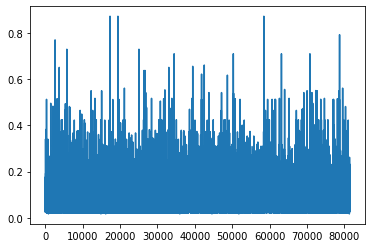

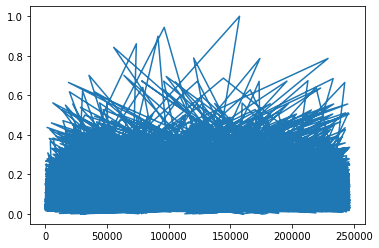

Weights:


{'livingSpace': 0.5559700569360018,
 'serviceCharge': 0.1486776019572856,
 'geo_bln': 0.08934671899639383,
 'geo_plz': 0.04517814951940015,
 'pricetrend': 0.04498563247590848,
 'lift': 0.02173499533313368,
 'yearConstructed': 0.020203552220869142,
 'yearConstructedRange': 0.01812434806454463,
 'regio1': 0.014221364976713804,
 'interiorQual': 0.007970143443902625,
 'hasKitchen': 0.007260652046149424,
 'regio2': 0.004836743808305599,
 'numberOfFloors': 0.0034590933157191304,
 'geo_krs': 0.0033434590478635656,
 'condition': 0.0031727484153658103,
 'thermalChar': 0.002394598020735733,
 'regio3': 0.0021998157436688183,
 'picturecount': 0.0014897771182285906,
 'typeOfFlat': 0.001428514627983395,
 'balcony': 0.001025878624231247,
 'firingTypes': 0.0006427548230440926,
 'floor': 0.0005050736499713173,
 'heatingCosts': 0.0003964277214605116,
 'heatingType': 0.00033844961957717336,
 'noRooms': 0.00029843988439947006,
 'noRoomsRange': 0.0002773557648513521,
 'cellar': 0.0002766778292881791,
 'tel

In [55]:
#with label encodeer
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)
prediction = tree.predict(X_test)
score_tree = tree.score(X_test, y_test)
mse_error_tree =  metrics.mean_squared_error(y_test, prediction)
rmse_tree = math.sqrt(mse_error_tree)
print('Score: ', score_tree)
print('RMSE: ', rmse_tree)

plt.plot(tree.predict(X_test))
plt.show()
plt.plot(y_test)
plt.show()

print("Weights:")
weights_tree =get_weight_dict(df, 'baseRent',tree)
weight_items_tree = weights_tree.items()
first_weights_tree = list(weight_items_tree)[:2]
weights_tree

Score:  0.9378008499270851
RMSE:  0.013121058488225288


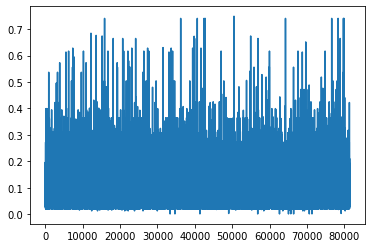

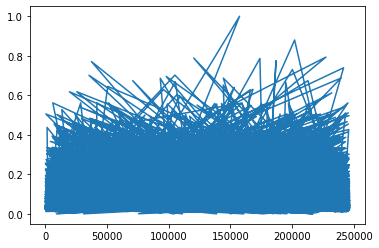

Weights:


{'geo_plz': 0.9579849001914803,
 'serviceCharge': 0.012108996155488815,
 'livingSpace': 0.009168355465505717,
 'noRooms': 0.007619190922324672,
 'pricetrend': 0.0016292621224298209,
 'yearConstructed': 0.0015040352774545605,
 'floor': 0.001261048101582093,
 'telekomTvOffer_NONE': 0.0012459410585645117,
 'numberOfFloors': 0.0012298285196084835,
 'condition_first_time_use': 0.0011948928548423834,
 'picturecount': 0.0010985837087859045,
 'noRoomsRange': 0.0010291306431218122,
 'thermalChar': 0.0010013095184807197,
 'interiorQual_normal': 0.00031658668811419897,
 'noParkSpaces': 0.00027275574231238307,
 'garden': 0.00021335184179140408,
 'hasKitchen': 0.00015930736151455386,
 'condition_mint_condition': 0.0001458012583934085,
 'lift': 0.00011817658582233891,
 'heatingCosts': 8.231285777612654e-05,
 'yearConstructedRange': 3.956884935626488e-05,
 'interiorQual_simple': 2.0338056567983378e-05,
 'condition_first_time_use_after_refurbishment': 2.021491469665439e-05,
 'cellar': 1.96263384692451

In [56]:
#with dummies
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_d, y_train_d)
prediction = tree.predict(X_test_d)
score_tree = tree.score(X_test_d, y_test_d)
mse_error_tree =  metrics.mean_squared_error(y_test_d, prediction)
rmse_tree = math.sqrt(mse_error_tree)
print('Score: ', score_tree)
print('RMSE: ', rmse_tree)

plt.plot(tree.predict(X_test_d))
plt.show()
plt.plot(y_test_d)
plt.show()

print("Weights:")
weights_tree =get_weight_dict(df_dummies, 'baseRent',tree)
weight_items_tree = weights_tree.items()
first_weights_tree = list(weight_items_tree)[:2]
weights_tree

Score:  0.8623922887095062
RMSE:  0.019527655682332175


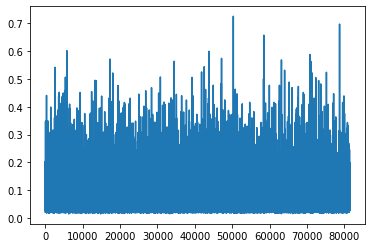

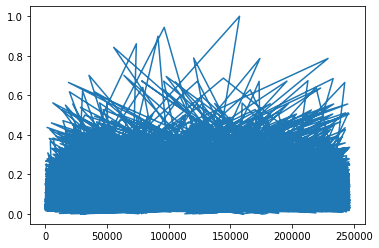

Weights:


{'livingSpace': 0.5044440665872884,
 'serviceCharge': 0.14241108963639013,
 'pricetrend': 0.05338450157846384,
 'geo_plz': 0.05067621281017947,
 'geo_bln': 0.04663060384557184,
 'regio1': 0.0427321313237335,
 'yearConstructed': 0.036079292280425335,
 'lift': 0.0126920250273588,
 'interiorQual': 0.012098641233348252,
 'yearConstructedRange': 0.009597609066463002,
 'regio3': 0.009283574351061216,
 'picturecount': 0.008192207645015487,
 'geo_krs': 0.008017054480986642,
 'regio2': 0.007993303019763774,
 'numberOfFloors': 0.0073775746229604545,
 'condition': 0.007250793435038555,
 'hasKitchen': 0.007169360481460631,
 'thermalChar': 0.00632696210015201,
 'floor': 0.0037494073925819615,
 'heatingType': 0.0034415367435427203,
 'typeOfFlat': 0.0033534505681101267,
 'firingTypes': 0.0031626888869706452,
 'noRooms': 0.002980303235513863,
 'heatingCosts': 0.0027217390135600094,
 'noParkSpaces': 0.0016959951911894335,
 'balcony': 0.0013985520444669882,
 'petsAllowed': 0.0012368575423698067,
 'noRoo

In [57]:
#with label encoder
random_forest = RandomForestRegressor(max_depth=15, random_state=0)
random_forest.fit(X_train, y_train)
prediction = random_forest.predict(X_test)
score_random_forest = random_forest.score(X_test, y_test)
mse_error_random_forest =  metrics.mean_squared_error(y_test, prediction)
rmse_random_forest = math.sqrt(mse_error_random_forest)
print('Score: ', score_random_forest)
print('RMSE: ', rmse_random_forest)

plt.plot(random_forest.predict(X_test))
plt.show()
plt.plot(y_test)
plt.show()

print("Weights:")
weights_random_forest = get_weight_dict(df, 'baseRent',random_forest)
weight_items_random_forest = weights_random_forest.items()
first_weights_random_forest = list(weight_items_random_forest)[:2]
weights_random_forest

Score:  0.9598019616159157
RMSE:  0.010548217508558626


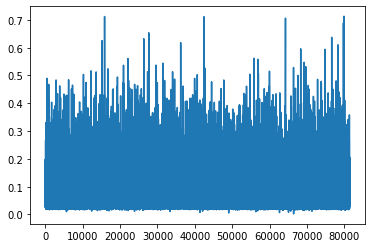

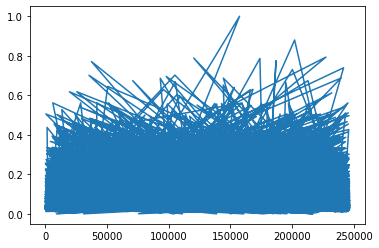

Weights:


{'geo_plz': 0.9406345803733286,
 'serviceCharge': 0.013400245419482266,
 'livingSpace': 0.010983072768005045,
 'noRooms': 0.008453511433654401,
 'pricetrend': 0.00520946591548322,
 'floor': 0.002516716070657194,
 'yearConstructed': 0.0023930389050808437,
 'picturecount': 0.0023625220673975816,
 'numberOfFloors': 0.0017049912794989874,
 'noRoomsRange': 0.0014248582366347836,
 'thermalChar': 0.0013396834496073279,
 'telekomTvOffer_NONE': 0.0011998713778919102,
 'condition_first_time_use': 0.0010969514557196563,
 'interiorQual_normal': 0.0008081757121452781,
 'noParkSpaces': 0.0007681452961128091,
 'yearConstructedRange': 0.0005630719484504062,
 'telekomTvOffer_ON_DEMAND': 0.0005105461696809548,
 'hasKitchen': 0.00046002620063774144,
 'condition_modernized': 0.0004402379067317223,
 'cellar': 0.0003787194507335191,
 'condition_ripe_for_demolition': 0.00037325143789456626,
 'garden': 0.00032133162343796586,
 'lift': 0.0003120499691219927,
 'heatingCosts': 0.00030881528644516375,
 'balcony':

In [58]:
#with dummies
random_forest = RandomForestRegressor(max_depth=15, random_state=0)
random_forest.fit(X_train_d, y_train_d)
prediction = random_forest.predict(X_test_d)
score_random_forest = random_forest.score(X_test_d, y_test_d)
mse_error_random_forest =  metrics.mean_squared_error(y_test_d, prediction)
rmse_random_forest = math.sqrt(mse_error_random_forest)
print('Score: ', score_random_forest)
print('RMSE: ', rmse_random_forest)

plt.plot(random_forest.predict(X_test_d))
plt.show()
plt.plot(y_test_d)
plt.show()

print("Weights:")
weights_random_forest = get_weight_dict(df_dummies, 'baseRent',random_forest)
weight_items_random_forest = weights_random_forest.items()
first_weights_random_forest = list(weight_items_random_forest)[:2]
weights_random_forest

### KNN Model

c:\users\jaxxi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\users\jaxxi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Score:  0.5753575645176563
RMSE:  0.03430365682835343


c:\users\jaxxi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


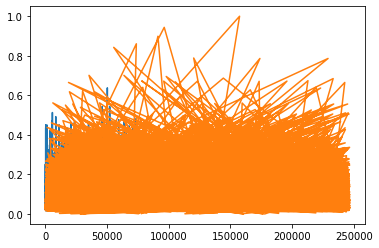

In [59]:
#with label encoder
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)
prediction = knn_model.predict(X_test)
score_knn = knn_model.score(X_test, y_test)
mse_error_knn =  metrics.mean_squared_error(y_test, prediction)
rmse_knn = math.sqrt(mse_error_knn)
print('Score: ', score_knn)
print('RMSE: ', rmse_knn)

plt.plot(knn_model.predict(X_test))
plt.plot(y_test)
plt.show()


In [ ]:
#with dummies
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train_d, y_train_d)
prediction = knn_model.predict(X_test_d)
score_knn = knn_model.score(X_test_d, y_test_d)
mse_error_knn =  metrics.mean_squared_error(y_test_d, prediction)
rmse_knn = math.sqrt(mse_error_knn)
print('Score: ', score_knn)
print('RMSE: ', rmse_knn)

plt.plot(knn_model.predict(X_test_d))
plt.plot(y_test_d)
plt.show()

c:\users\jaxxi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\users\jaxxi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Score:  0.8013606397933196
RMSE:  0.023448188683481197


c:\users\jaxxi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


<h3> Result <h3>

In [ ]:
results_f= {"Model": ["Linear Regression", "Ridge Regression","SGD Regressor","Decision Tree","Random Forest","KNN"], 
          "Score": [score_lineReg, score_reg, score_sgd, score_tree, score_random_forest, score_knn], 
          "RMSE Error": [rmse_lineReg, rmse_reg, rmse_sgd, rmse_tree, rmse_random_forest, rmse_knn],
         "Important Features": [first_weights_lineReg, first_weights_reg, first_weights_sgd, first_weights_tree, first_weights_random_forest, "Undefined"]}
df_results_f = pd.DataFrame(data=results)
df_results_f

In [ ]:
results_d= {"Model": ["Linear Regression", "Ridge Regression","SGD Regressor","Decision Tree","Random Forest","KNN"], 
          "Score": [score_lineReg, score_reg, score_sgd, score_tree, score_random_forest, score_knn], 
          "RMSE Error": [rmse_lineReg, rmse_reg, rmse_sgd, rmse_tree, rmse_random_forest, rmse_knn],
         "Important Features": [first_weights_lineReg, first_weights_reg, first_weights_sgd, first_weights_tree, first_weights_random_forest, "Undefined"]}
df_results_d = pd.DataFrame(data=results)
df_results_d

## 4. Map Visualization

In [ ]:
#imports
import math

In [ ]:
#Load Location Dataframe
path_plz = "plz_geocoord.csv"
df_plz = pd.read_csv(path_plz)
pd.set_option('display.max_columns', None)
df_plz.columns = ['geo_plz', 'lat', 'lon']
df_plz = df_plz.set_index('geo_plz')

In [ ]:
geo_df = df[["baseRent", "geo_plz"]].copy()
geo_df['count'] = 1

In [ ]:
geo_df = geo_df.groupby('geo_plz', as_index=False).sum()
geo_df['meanRent'] = geo_df['baseRent']/(geo_df['count']*geo_df['count'])
#geo_df['logRent'] = np.log2(geo_df['meanRent'])**(1/2)
#geo_df['logRent'] = geo_df['logRent']*geo_df['count']
#geo_df.head(20)

In [ ]:
#add Lat and Lon to the DF
def merge_df(df1, df2, att):
    t0 = time.time()
    results_df = df1.merge(df2, how='inner', on=att)
    t1 = time.time()
    total = t1-t0
    print("It took {} Sec. to get {} Lat and Lon Data Pionts".format(total, results_df.shape[0]))
    return results_df

geo_df = merge_df(geo_df, df_plz, 'geo_plz')

In [ ]:
"""
import geopandas as gpd
fp = "geomap/vg2500_bld.shp"
map_df = gpd.read_file(fp)
map_df.head()
map_df.plot()
"""

In [ ]:
plt.rcParams["figure.figsize"] = (24,37)
plt.scatter(x=geo_df['lon'], y=geo_df['lat'], s=geo_df["meanRent"])
plt.show()

In [ ]:


plt.rcParams["figure.figsize"] = (24,37)
#plt.scatter(x=geo_df['lon'], y=geo_df['lat'], s=geo_df["meanRent"])
#plt.show()



img = plt.imread("geomap/germany_lines.png")
fig, ax = plt.subplots()
ax.scatter(x=geo_df['lon'], y=geo_df['lat'], s=geo_df["meanRent"])
ax.imshow(img, extent=[5.5, 15.5, 47, 55.22])
plt.show()

In [ ]:
img = plt.imread("rain.jpg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-5, 80, -5, 30])
ax.scatter(TMIN, PRCP, color="#ebb734")
plt.show()